# Result Summary for the NeurIPS Submission

Select which dataset, and which ground truth file.

In [1]:
using DelimitedFiles
using Statistics, StatsBase
using Plots, StatsPlots

BENCHMARK_CHOICE = "sachs_ifmtruth_results"
SIGMA_CHOICE_ALL = "sachs_sigma_all"
BENCHMARK_PATH =  "experiments/";

println("Benchmark chosen!")

Benchmark chosen!


Load ground truth and results for different output variables. Each will be a 100 x $d$ matrix, with $d$ = 16 for Sachs et al, and $d$ = 56 for DREAM. There are three IFM models, plain regression (`ifm_1`), IPW (`ifm_2`) and covariate shift regression (`ifm_3`). To calculate the "proportional mean squared error" measure later on, we also need the true variance of each outcome variable at each regime, which is stored in the 100 x $d$ matrix `true_var_y`.

*[NOTICE: FOR THE MOMENT, COVARIATE SHIFT REGRESSION WASNT DONE FOR THE DREAM DATASET. IT JUST REPEATS `ifm_1`.]*

In [2]:
sigma_all = readdlm(BENCHMARK_PATH * SIGMA_CHOICE_ALL * ".csv", ',', Int64)

true_y = readdlm(BENCHMARK_PATH * BENCHMARK_CHOICE * "_true.csv", ',')
y_hat_blackbox = readdlm(BENCHMARK_PATH * BENCHMARK_CHOICE * "_blackbox.csv", ',')
y_hat_dag = readdlm(BENCHMARK_PATH * BENCHMARK_CHOICE * "_y_hat_dag.csv", ',')
y_hat_ifm_1 = readdlm(BENCHMARK_PATH * BENCHMARK_CHOICE * "_y_hat_ifm_1_mlp.csv", ',')
y_hat_ifm_2 = readdlm(BENCHMARK_PATH * BENCHMARK_CHOICE * "_y_hat_ifm_3_mlp.csv", ',')
y_hat_ifm_3 = readdlm(BENCHMARK_PATH * BENCHMARK_CHOICE * "_y_hat_ifm_4_mlp.csv", ',')
true_var_y = readdlm(BENCHMARK_PATH * BENCHMARK_CHOICE * "_true_var_y.csv", ',')

num_problems = 100
println("Files loaded!")

ArgumentError: ArgumentError: Cannot open 'experiments/sachs_sigma_all.csv': not a file


Now, calculate summary statistics. This is done by taking, for each of the 100 outcome problems, a measure of comparison between the ground truth $d$-dimensional vector against the estimated $d$-dimensional vector. We drop all training set rgimes though, `include_sigma` below refers to unseen regimes.

`rmse` is root mean squared error. Not too meaningful without knowing the scale of the variable. So we have also `pmse`, which is the MSE divided by the variance of the outcome variable in each problem.

The other main measure is rank correlation (Spearman's $\rho$).

In [78]:
rmse_dag, spearman_dag, prmse_dag = zeros(num_problems), zeros(num_problems), zeros(num_problems)
rmse_ifm1, spearman_ifm1, prmse_ifm1 = zeros(num_problems), zeros(num_problems), zeros(num_problems)
rmse_ifm2, spearman_ifm2, prmse_ifm2 = zeros(num_problems), zeros(num_problems), zeros(num_problems)
rmse_ifm3, spearman_ifm3, prmse_ifm3 = zeros(num_problems), zeros(num_problems), zeros(num_problems)
rmse_blackbox, spearman_blackbox, prmse_blackbox = zeros(num_problems), zeros(num_problems), zeros(num_problems)

include_sigma = findall(sum(sigma_all, dims = 2)[:, 1] .> 1) # Only include regimes with two or more non-zero actions

for p = 1:num_problems

    rmse_dag[p] = sqrt(mean((true_y[p, include_sigma] - y_hat_dag[p, include_sigma]).^2))
    rmse_ifm1[p] = sqrt(mean((true_y[p, include_sigma] - y_hat_ifm_1[p, include_sigma]).^2))
    rmse_ifm2[p] = sqrt(mean((true_y[p, include_sigma] - y_hat_ifm_2[p, include_sigma]).^2))
    rmse_ifm3[p] = sqrt(mean((true_y[p, include_sigma] - y_hat_ifm_3[p, include_sigma]).^2))
    rmse_blackbox[p] = sqrt(mean((true_y[p, include_sigma] - y_hat_blackbox[p, include_sigma]).^2))

    spearman_dag[p] = corspearman(true_y[p, include_sigma], y_hat_dag[p, include_sigma])
    spearman_ifm1[p] = corspearman(true_y[p, include_sigma], y_hat_ifm_1[p, include_sigma])
    spearman_ifm2[p] = corspearman(true_y[p, include_sigma], y_hat_ifm_2[p, include_sigma])
    spearman_ifm3[p] = corspearman(true_y[p, include_sigma], y_hat_ifm_3[p, include_sigma])
    spearman_blackbox[p] = corspearman(true_y[p, include_sigma], y_hat_blackbox[p, include_sigma])

    prmse_dag[p] = mean((true_y[p, include_sigma] - y_hat_dag[p, include_sigma]).^2 ./ true_var_y[p, include_sigma])
    prmse_ifm1[p] = mean((true_y[p, include_sigma] - y_hat_ifm_1[p, include_sigma]).^2 ./ true_var_y[p, include_sigma])
    prmse_ifm2[p] = mean((true_y[p, include_sigma] - y_hat_ifm_2[p, include_sigma]).^2 ./ true_var_y[p, include_sigma])
    prmse_ifm3[p] = mean((true_y[p, include_sigma] - y_hat_ifm_3[p, include_sigma]).^2 ./ true_var_y[p, include_sigma])
    prmse_blackbox[p] = mean((true_y[p, include_sigma] - y_hat_blackbox[p, include_sigma]).^2 ./ true_var_y[p, include_sigma])

end

println("Summary comparisons done!")

Summary comparisons done!


Print summary statistics, finally:

In [79]:
max_prob=100

println() 
println("ALL RESULTS:")
println("------------")
println("RANKCORR (blackbox)   : ", mean(spearman_blackbox[1:max_prob]))
println("RANKCORR (DAG)        : ", mean(spearman_dag[1:max_prob]))
println("RANKCORR (IFM1)       : ", mean(spearman_ifm1[1:max_prob]))
println("RANKCORR (IFM2)       : ", mean(spearman_ifm2[1:max_prob]))
println("RANKCORR (IFM3)       : ", mean(spearman_ifm3[1:max_prob]))
println()
println("pRMSE (blackbox)  : ", mean(prmse_blackbox[1:max_prob]))
println("pRMSE (DAG)       : ", mean(prmse_dag[1:max_prob]))
println("pRMSE (IFM1)      : ", mean(prmse_ifm1[1:max_prob]))
println("pRMSE (IFM2)      : ", mean(prmse_ifm2[1:max_prob]))
println("pRMSE (IFM3)      : ", mean(prmse_ifm3[1:max_prob]))
println()


ALL RESULTS:
------------
RANKCORR (blackbox)   : 0.9303616272743429
RANKCORR (DAG)        : 0.5024874835309617
RANKCORR (IFM1)       : 0.9423978919631094
RANKCORR (IFM2)       : 0.7367325428194994
RANKCORR (IFM3)       : 0.9423978919631094

pRMSE (blackbox)  : 0.17371024332314383
pRMSE (DAG)       : 1.3366634960787218
pRMSE (IFM1)      : 0.18493019758779156
pRMSE (IFM2)      : 0.7691801645129572
pRMSE (IFM3)      : 0.18493019758779156



This is an example of plot: 

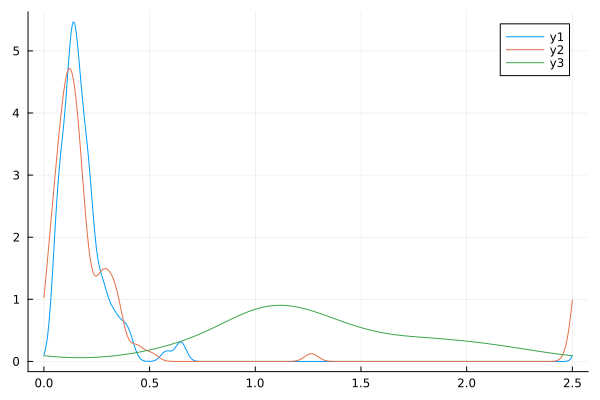

In [80]:
using KernelDensity, HypothesisTests

plot(kde(prmse_ifm1, boundary=(0, 2.5)))
plot!(kde(prmse_blackbox, boundary=(0, 2.5)))
plot!(kde(prmse_dag, boundary=(0, 2.5)))



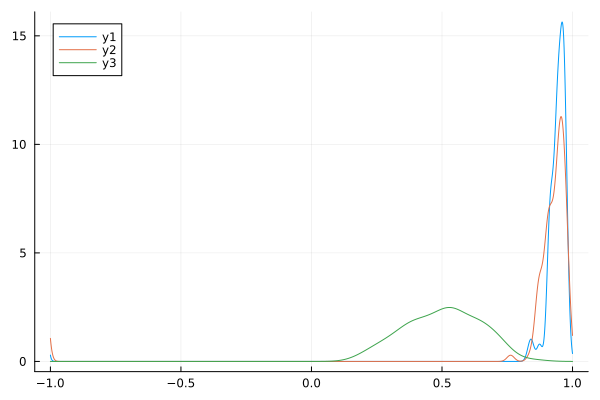

In [81]:
plot(kde(spearman_ifm1, boundary=(-1, 1)))
plot!(kde(spearman_blackbox, boundary=(-1, 1)))
plot!(kde(spearman_dag, boundary=(-1, 1)))

Statistical tests:

In [82]:
f = ApproximateTwoSampleKSTest(prmse_ifm1, prmse_blackbox)
println("Same distribution (blackbox vs IFM1)? P-value under the null: ", pvalue(f))
f = ApproximateTwoSampleKSTest(prmse_ifm1, prmse_dag)
println("Same distribution (DAG vs IFM1)? P-value under the null: ", pvalue(f))

Same distribution (blackbox vs IFM1)? P-value under the null: 0.03663105270711932
Same distribution (DAG vs IFM1)? P-value under the null: 1.2763006896119949e-39
